In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, einops, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f, t/10**9

(0, 15.835398144)

In [ ]:
!pip install "monai[einops]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import nibabel as nib
import time
import glob
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset, set_track_meta
from monai.handlers.utils import from_engine
from monai.losses import SSIMLoss
from monai.inferers import sliding_window_inference
from monai.metrics import SSIMMetric
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized,
    RandSpatialCropSamplesd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    NormalizeIntensityd,
    ToTensord
)


In [ ]:
# # def patchData(datadir):
# #     for
path = '/content/drive/MyDrive/PARSE/PAS/train/PA000005/image/PA000005.nii.gz'
vol =  nib.load(path)
vol = vol.get_fdata()

In [ ]:
# root = '/content/drive/MyDrive/PARSE/Pretrain/train'

# glob.glob(os.path.join(root, 'images',"*.nii.gz"))

(128, 128, 128)


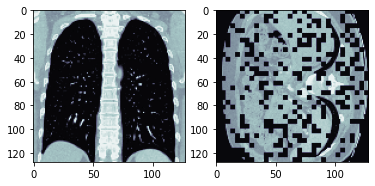

In [ ]:
orig = vol
m=0.3
d = 32
mean = np.mean(orig)
mask = np.random.choice([0,1], size = (d,d,d), p=[m,1-m])
shp = vol.shape
mask = np.kron(mask,np.ones((shp[0]//d, shp[1]//d, shp[2]//d)))
patched = orig*mask

d = 1

_ , ax = plt.subplots(1,2)
# print(len(ax))
ax[0].imshow(np.rot90(orig[:,90,:]), cmap = 'bone')
# plt.imshow(mask, cmap = 'bone')
print(mask.shape)
ax[1].imshow(patched[:,:,d], cmap = 'bone')

In [ ]:
del sample

In [ ]:
# path = '/content/drive/MyDrive/PARSE/PAS/train'
# # print(np.array(list(os.walk(path))))
# # print(root, dirs)
# s = time.time()
# imgs = []

# for root, dirs, files in os.walk(path):
#     if root.split('/')[-1]=='image':
#         # print(files)
#         # print(os.path.join(root,files[0]))
#         imgs.append(os.path.join(root,files[0]))

# print(time.time()-s)
# # path = '/content/drive/MyDrive/PARSE/PAS/train/PA000005/image/PA000005.nii.gz'

In [ ]:
def patchData(datadir, newdir):
    # print(os.walk(datadir))
    for root, dirs, files in os.walk(datadir):
        # print(root,dirs,files)
        if root.split('/')[-1]=='image':
            imgpath = os.path.join(root,files[0])
            img =  nib.load(imgpath)
            orig = img.get_fdata()
            m = 0.3
            d = 32
            mean = np.mean(orig)
            mask = np.random.choice([0,1], size = (d,d,d), p=[m,1-m])
            shp = orig.shape
            mask = np.kron(mask,np.ones((shp[0]//d, shp[1]//d, shp[2]//d)))
            patched = orig*mask
            # print(patched.shape)
            # patched = Image.fromarray(patched)
            patched = nib.Nifti1Image(patched, img.affine)
            patched.to_filename(os.path.join(newdir,'images',files[0]))
            shutil.copy(imgpath, os.path.join(newdir,'labels',files[0]))

            mask = np.random.choice([0,1], size = (d,d,d), p=[m,1-m])
            mask = np.kron(mask,np.ones((shp[0]//d, shp[1]//d, shp[2]//d)))
            patched = orig*mask
            # print(patched.shape)
            # patched = Image.fromarray(patched)
            patched = nib.Nifti1Image(patched, img.affine)

            patched.to_filename(os.path.join(newdir,'images',files[0]).replace('.n','2.n'))
            shutil.copy(imgpath, os.path.join(newdir,'labels',files[0]).replace('.n','2.n'))

In [ ]:
datadir = '/content/drive/MyDrive/PARSE/PAS/val'
newdir = '/content/drive/MyDrive/PARSE/Pretrain/val'

patchData(datadir, newdir)

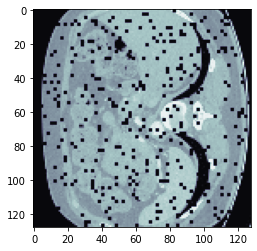

In [ ]:
path = '/content/drive/MyDrive/PARSE/Pretrain/train/images/PA0000052.nii.gz'
img =  nib.load(path)
orig = img.get_fdata()
plt.imshow(orig[:,:,1], cmap = 'bone')

In [ ]:
# datadir = '/content/drive/MyDrive/PARSE/PAS/val'
# newdir = '/content/drive/MyDrive/PARSE/Pretrain/val'

# patchData(datadir, newdir)

In [ ]:
root_dir = '/content/drive/MyDrive/PARSE/PAS'
print(root_dir)

/content/drive/MyDrive/PARSE/PAS


In [ ]:
len(os.listdir('/content/drive/MyDrive/PARSE/Pretrain/val/images'))

10

In [ ]:
size = 96

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.6, 1.6, 1.6),
            mode=("bilinear", "nearest"),
        ),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=-10,
        #     a_max=10,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,
        # ),
        RandSpatialCropSamplesd(
            keys=["image", "label"],
            roi_size=(size,size,size),
            num_samples=1,
            random_size=False,
        ),
        # Resized(
        #     keys=["image", "label"],
        #     spatial_size=(size,size,size),
        # ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.50,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.50,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.50,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        NormalizeIntensityd(keys=["image", "label"], nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys=["image", "label"], factors=0.1, prob=1.0),
        RandShiftIntensityd(keys=["image", "label"], offsets=0.1, prob=1.0),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.6, 1.6, 1.6),
            mode=("bilinear", "nearest"),
        ),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-10, a_max=10, b_min=0.0, b_max=1.0, clip=True
        # ),
        NormalizeIntensityd(keys=["image", "label"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
m = 50

In [ ]:
root = f"/content/drive/MyDrive/PARSE/Pretrain/masked{m}/train"
train_images = sorted(glob.glob(os.path.join(root, 'images', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root, 'labels', "*.nii.gz")))

root = f"/content/drive/MyDrive/PARSE/Pretrain/masked{m}/val"
val_images = sorted(glob.glob(os.path.join(root, 'images', "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(root, 'labels', "*.nii.gz")))

traind = [{'image':i[0], 'label':i[1]} for i in zip(train_images, train_labels)]
vald = [{'image':i[0], 'label':i[1]} for i in zip(val_images, val_labels)]

In [ ]:
len(traind), len(vald)

(180, 20)

In [ ]:
os.cpu_count()

2

In [ ]:
train_ds = CacheDataset(
    data = traind,
    transform = train_transforms,
    num_workers=2
)

val_ds = CacheDataset(
    data = vald,
    transform = val_transforms,
    num_workers=2
)

Loading dataset: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


In [ ]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

(<matplotlib.image.AxesImage at 0x7f7c0e8ea9a0>, torch.Size([1, 96, 96, 96]))

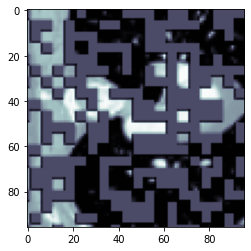

In [ ]:
sample = train_ds[0][0]
plt.imshow(sample['image'][0,:,:,20], cmap = 'bone'), sample['image'].shape

In [ ]:
sample['image'].shape, len(train_ds)

(torch.Size([1, 96, 96, 96]), 180)

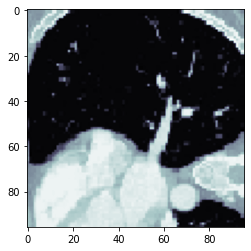

In [ ]:
plt.imshow(sample['label'][0,:,:,20], cmap = 'bone')

In [ ]:
val_ds[0]['image'].shape

torch.Size([1, 160, 160, 160])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(size, size, size),
    in_channels=1,
    out_channels=1,
    depths = (3, 2, 2, 2),
    num_heads = (6, 6, 12, 24),
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/PARSE/Pretrain/weights/best_metric_model_swin2.pth")

In [ ]:
weight = torch.load(f"/content/drive/MyDrive/PARSE/Pretrain/weights/swin_pre{m}.pth", map_location=torch.device('cpu'))
model.load_state_dict(weight)


<All keys matched successfully>

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
loss_function = SSIMLoss(spatial_dims=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler()

In [ ]:
# while True:
#   pass
# model.to(torch.device('cpu'))

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    count = 0
    ssim = 0
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (size, size, size), 2, model)
            global val_labels_list, val_outputs_list
            # val_labels_list = decollate_batch(val_labels)
            # val_outputs_list = decollate_batch(val_outputs)

            data_range = val_labels.max().unsqueeze(0).to(device)
            # print(val_outputs, len(val_outputs), data_range)
            # try:
            #     print(val_outputs.keys())
            # except:
            #     pass
            # ssim += sum(SSIMMetric(data_range=data_range,spatial_dims=3)._compute_metric(val_outputs_list[i], val_labels_list[i]) for i in range(len(val_outputs_list)))
            ssim += SSIMMetric(data_range=data_range,spatial_dims=3)._compute_metric(val_outputs, val_labels)
            # ssim += SSIMMetric(data_range=data_range,spatial_dims=3)(y_pred=val_outputs, y=val_labels)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, max_iterations)
            )
            count += len(val_labels)
            # print(ssim)
        mean_dice_val = ssim/count
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        data_range = x.max().unsqueeze(0).to(device)

        optimizer.zero_grad()
        # with torch.cuda.amp.autocast():
        #     logit_map = model(x)
        #     loss = loss_function(logit_map, y, data_range)

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        # epoch_loss += loss.item()

        logit_map = model(x)
        # data_range = x.max().unsqueeze(0).to(device)

        loss = loss_function(logit_map, y, data_range)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            print(dice_val, dice_val_best)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), f"/content/drive/MyDrive/PARSE/Pretrain/weights/swin_pre{m}.pth"
                )
                print(
                    "Model Was Saved ! Current Best Avg. SSIM: {} Current Avg. SSIM: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. SSIM: {} Current Avg. SSIM: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1

    return global_step, dice_val_best, global_step_best

In [ ]:
epoch_loss_values = []
metric_values = []

In [ ]:
max_iterations = 2000
eval_num = 200
global_step = 0
dice_val_best = 0.73
global_step_best = 0

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
# model.load_state_dict(torch.load(os.path.join(root_dir, "/content/drive/MyDrive/PARSE/Pretrain/weights/best_metric_model_swin.pth")))

Validate (X / X Steps) (dice=X.X):   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")

Training (200 / 2000 Steps) (loss=0.25836):  12%|█▏        | 21/180 [02:06<1:12:49, 27.48s/it]

tensor([[0.6983]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.6983]], device='cuda:0')


Training (400 / 2000 Steps) (loss=0.27151):  23%|██▎       | 41/180 [02:40<1:01:00, 26.33s/it]

tensor([[0.7110]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7110]], device='cuda:0')


Training (600 / 2000 Steps) (loss=0.21969):  34%|███▍      | 61/180 [03:17<52:18, 26.38s/it]

tensor([[0.7115]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7115]], device='cuda:0')


Training (800 / 2000 Steps) (loss=0.25356):  45%|████▌     | 81/180 [03:56<43:42, 26.49s/it]

tensor([[0.7239]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7239]], device='cuda:0')


Training (1000 / 2000 Steps) (loss=0.23892):  56%|█████▌    | 101/180 [04:33<34:50, 26.46s/it]

tensor([[0.7238]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7238]], device='cuda:0')


Training (1200 / 2000 Steps) (loss=0.24708):  67%|██████▋   | 121/180 [05:11<26:02, 26.48s/it]

tensor([[0.7252]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7252]], device='cuda:0')


Training (1400 / 2000 Steps) (loss=0.23065):  78%|███████▊  | 141/180 [05:49<17:07, 26.34s/it]

tensor([[0.7223]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7223]], device='cuda:0')


Training (1600 / 2000 Steps) (loss=0.26124):  89%|████████▉ | 161/180 [06:27<08:21, 26.38s/it]

tensor([[0.7222]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7222]], device='cuda:0')


Training (1800 / 2000 Steps) (loss=0.21766):   1%|          | 1/180 [01:24<4:11:57, 84.45s/it]

tensor([[0.7290]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7290]], device='cuda:0')


Training (2000 / 2000 Steps) (loss=0.18466):  12%|█▏        | 21/180 [02:02<1:09:48, 26.34s/it]

tensor([[0.7268]], device='cuda:0') 0.73
Model Was Not Saved ! Current Best Avg. SSIM: 0.73 Current Avg. SSIM: tensor([[0.7268]], device='cuda:0')


Training (2159 / 2000 Steps) (loss=0.22910): 100%|██████████| 180/180 [07:02<00:00,  2.35s/it]


/usr/local/lib/python3.8/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


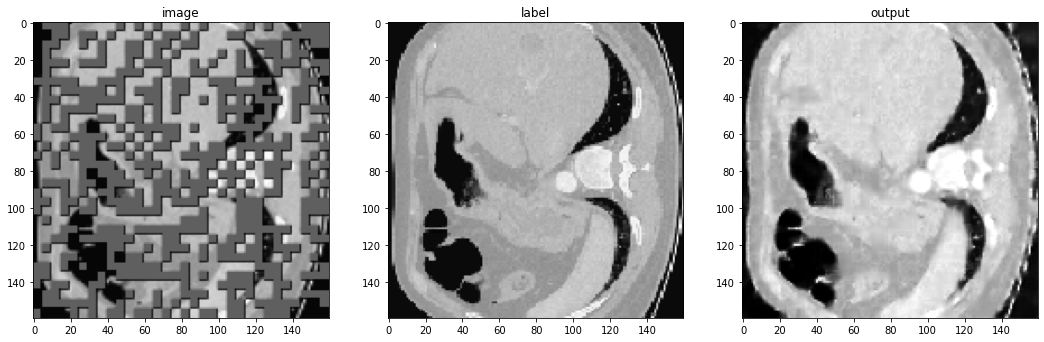

In [ ]:
case_num = 4; sl = 20
root_dir = '/content/drive/MyDrive/PARSE/Pretrain/weights'
model.load_state_dict(torch.load(os.path.join(root_dir, f"swin_pre{m}.pth")))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SwinUNETR(
#     img_size=(size, size, size),
#     in_channels=1,
#     out_channels=1,
#     feature_size=24,
#     use_checkpoint=True,
# ).to(device)

model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    img = val_ds[0]["image"]
    label = val_ds[0]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (size, size, size), 2, model, overlap=0
    )
    # min=np.min(val_outputs)        # result=144
    # max=np.max(val_outputs)        # result=216
    pixvals = val_outputs.cpu().numpy()[0,0,:, :, sl]
    minval = np.percentile(pixvals, 2)
    maxval = np.percentile(pixvals, 98)
    pixvals = np.clip(pixvals, minval, maxval)
    pixvals = ((pixvals - minval) / (maxval - minval)) * 255
    # Image.fromarray(pixvals.astype(np.uint8))
    # pixvalsImage.fromarray(pixvals.astype(np.uint8))
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, sl], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, sl], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        pixvals, cmap='gray'
    )
    plt.show()

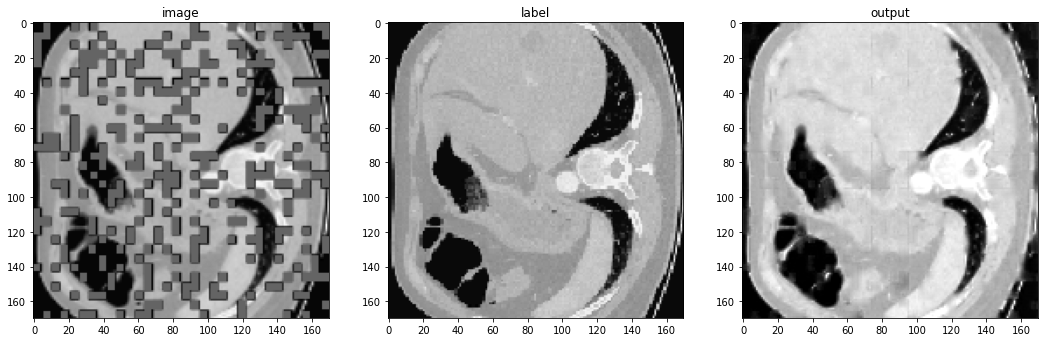

In [ ]:
case_num = 4; sl = 20
root_dir = '/content/drive/MyDrive/PARSE/Pretrain/weights'
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SwinUNETR(
#     img_size=(size, size, size),
#     in_channels=1,
#     out_channels=1,
#     feature_size=24,
#     use_checkpoint=True,
# ).to(device)

model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    img = val_ds[0]["image"]
    label = val_ds[0]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (size, size, size), 2, model, overlap=0
    )
    # min=np.min(val_outputs)        # result=144
    # max=np.max(val_outputs)        # result=216
    pixvals = val_outputs.cpu().numpy()[0,0,:, :, sl]
    minval = np.percentile(pixvals, 2)
    maxval = np.percentile(pixvals, 98)
    pixvals = np.clip(pixvals, minval, maxval)
    pixvals = ((pixvals - minval) / (maxval - minval)) * 255
    # Image.fromarray(pixvals.astype(np.uint8))
    # pixvalsImage.fromarray(pixvals.astype(np.uint8))
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, sl], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, sl], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        pixvals, cmap='gray'
    )
    plt.show()

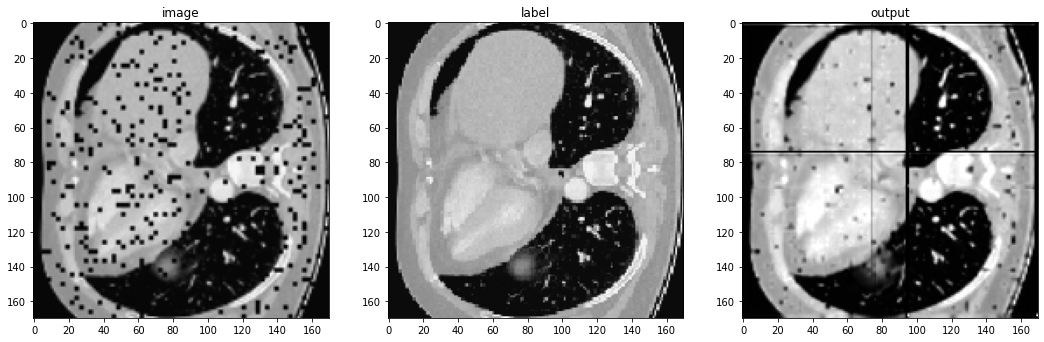

In [ ]:
case_num = 4; sl = 40
root_dir = '/content/drive/MyDrive/PARSE/Pretrain/weights'
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SwinUNETR(
#     img_size=(size, size, size),
#     in_channels=1,
#     out_channels=1,
#     feature_size=24,
#     use_checkpoint=True,
# ).to(device)

model.eval()
with torch.no_grad():
    # img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    img = val_ds[0]["image"]
    label = val_ds[0]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (size, size, size), 2, model, overlap=0
    )
    # min=np.min(val_outputs)        # result=144
    # max=np.max(val_outputs)        # result=216
    pixvals = val_outputs.cpu().numpy()[0,0,:, :, sl]
    minval = np.percentile(pixvals, 5)
    maxval = np.percentile(pixvals, 98)
    pixvals = np.clip(pixvals, minval, maxval)
    pixvals = ((pixvals - minval) / (maxval - minval)) * 255
    # Image.fromarray(pixvals.astype(np.uint8))
    # pixvalsImage.fromarray(pixvals.astype(np.uint8))
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, sl], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, sl], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        pixvals, cmap='gray'
    )
    plt.show()

In [ ]:
pixvals.min()

0.0

In [ ]:
x = torch.ones([1,3,3,3])/2 # ground truth
y = torch.ones([1,3,3,3])/2 # prediction
y[0,0,0,0]=2
data_range = x.max().unsqueeze(0)
# the following line should print 1.0 (or 0.9999)
print(SSIMMetric(win_size=2,data_range=data_range,spatial_dims=2)._compute_metric(x,y), data_range, x.shape)

tensor(0.9167) tensor([0.5000]) torch.Size([1, 3, 3, 3])
